In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os



In [2]:
!pip install --upgrade pip

  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/47/6a/453160888fab7c6a432a6e25f8afe6256d0d9f2cbd25971021da6491d899/pip-23.3.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.2.1
    Uninstalling pip-23.2.1:
      Successfully uninstalled pip-23.2.1


In [3]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 38.5 MB/s eta 0:00:00


In [4]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math


In [5]:
def unix_dateparse(timestamp):
    return datetime.utcfromtimestamp(int(timestamp))


In [6]:
df_data = pd.read_csv('../input/data-ethusdt4/BINANCE_ETHUSDT 1D_43bf8.csv', 
                         index_col='time', 
                         parse_dates=['time'], 
                         date_parser=unix_dateparse)

In [7]:
df_data

,open,high,low,close,Valley level,Weak level,Grow level,Peak level,long_signal,short_signal,...,max_runup,position_avg_price,MACD_hist,RSI,MFI,Knn Classifier Line,Average Knn Classifier Line,TWAP,Volume,Volume MA
time,,,,,,,,,,,,,,,,,,,,,
2017-08-17,301.13,312.18,298.00,302.00,298.00,298.00,312.18,312.18,0.0,0.0,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,303.3275,7030.71034,NaN
2017-08-18,302.00,311.79,283.94,293.96,312.18,283.94,283.94,283.94,0.0,0.0,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,297.9225,9537.84646,NaN
2017-08-19,293.96,299.90,278.00,290.91,312.18,283.94,283.94,278.00,0.0,0.0,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,290.6925,2146.19773,NaN
2017-08-20,290.91,300.53,282.85,299.10,312.18,283.94,283.94,278.00,0.0,0.0,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,293.3475,2510.13871,NaN
2017-08-21,299.10,346.52,294.60,323.29,278.00,294.60,346.52,346.52,0.0,0.0,...,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,315.8775,5219.44542,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-15,1979.40,2062.40,1967.01,2058.48,1521.00,1751.00,1800.00,2136.99,0.0,0.0,...,834002.847978,1751.000000,74.219908,67.245309,64.258295,1987.971889,1738.789424,2016.8225,421870.80320,371918.861210
2023-11-16,2058.49,2090.40,1939.10,1961.77,1521.00,1751.00,1800.00,2136.99,1.0,0.0,...,834002.847978,1751.000000,52.218107,56.365480,62.035594,2002.422644,1744.305242,2012.4400,545286.12970,385456.533090
2023-11-17,1961.77,1991.50,1904.00,1960.82,1521.00,1751.00,1800.00,2136.99,0.0,0.0,...,834002.847978,1851.047901,34.370744,56.269171,60.968857,2000.740356,1749.148697,1954.5225,401097.91070,399365.441715


In [8]:
columns_to_drop = ['equity', 'position_size', 'cash', 'net_profit', 'open_profit', 'max_drawdown', 'max_runup', 'position_avg_price', 'delete_pivot', 'pivot_offset', 'trade_event', 'pivot_price']
df_data = df_data.drop(columns=columns_to_drop)

In [9]:
df_data = df_data[:-1]

In [10]:
df_data

,open,high,low,close,Valley level,Weak level,Grow level,Peak level,long_signal,short_signal,...,invalid_count,LT_attr,MACD_hist,RSI,MFI,Knn Classifier Line,Average Knn Classifier Line,TWAP,Volume,Volume MA
time,,,,,,,,,,,,,,,,,,,,,
2017-08-17,301.13,312.18,298.00,302.00,298.00,298.00,312.18,312.18,0.0,0.0,...,0.0,1.0,NaN,NaN,NaN,NaN,NaN,303.3275,7030.71034,NaN
2017-08-18,302.00,311.79,283.94,293.96,312.18,283.94,283.94,283.94,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,297.9225,9537.84646,NaN
2017-08-19,293.96,299.90,278.00,290.91,312.18,283.94,283.94,278.00,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,290.6925,2146.19773,NaN
2017-08-20,290.91,300.53,282.85,299.10,312.18,283.94,283.94,278.00,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,293.3475,2510.13871,NaN
2017-08-21,299.10,346.52,294.60,323.29,278.00,294.60,346.52,346.52,0.0,0.0,...,0.0,1.0,NaN,NaN,NaN,0.000000,NaN,315.8775,5219.44542,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-14,2053.65,2064.96,1936.60,1979.39,1521.00,1751.00,1800.00,2136.99,0.0,0.0,...,4.0,1.0,78.125958,61.619500,64.280277,1962.396400,1733.043902,2008.6500,481909.73300,372383.773315
2023-11-15,1979.40,2062.40,1967.01,2058.48,1521.00,1751.00,1800.00,2136.99,0.0,0.0,...,4.0,1.0,74.219908,67.245309,64.258295,1987.971889,1738.789424,2016.8225,421870.80320,371918.861210
2023-11-16,2058.49,2090.40,1939.10,1961.77,1521.00,1751.00,1800.00,2136.99,1.0,0.0,...,0.0,1.0,52.218107,56.365480,62.035594,2002.422644,1744.305242,2012.4400,545286.12970,385456.533090


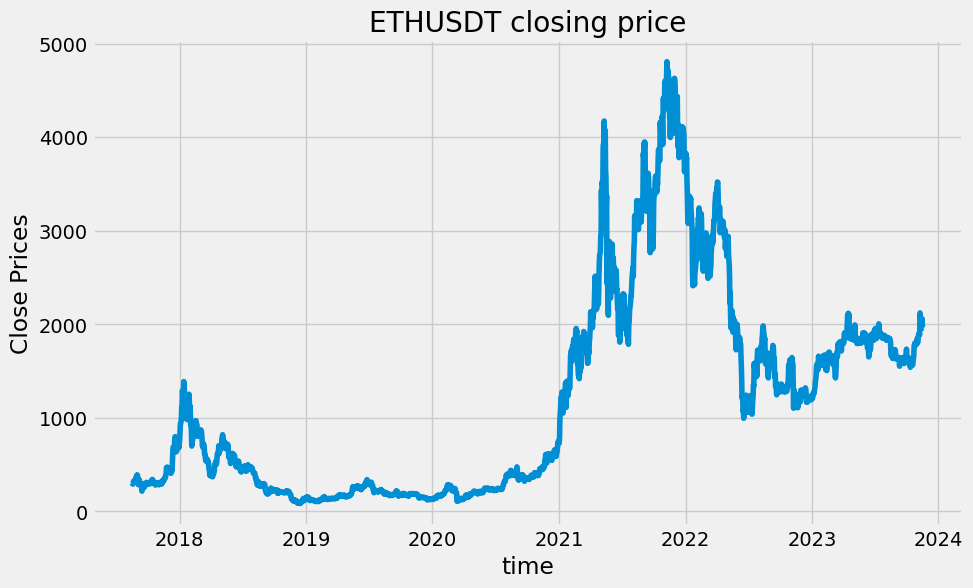

In [11]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('time')
plt.ylabel('Close Prices')
plt.plot(df_data['close'])
plt.title('ETHUSDT closing price')
plt.show()

In [12]:
df_data["TWAP"] = (df_data["TWAP"]-df_data["close"])/df_data["close"]
df_data["Volume"] = df_data['Volume'] / df_data['Volume MA'] - 1
df_data.drop(columns=['Volume MA'], inplace=True)
df_data["change_oc"] = (df_data["close"]-df_data["open"])/df_data["open"]
df_data["change_hl"] = (df_data["high"]-df_data["low"])/df_data["low"]
df_data["close_quantile"] = (df_data["close"]-df_data["low"])/(df_data["high"]-df_data["low"])
df_data["Valley level"] = (df_data["Valley level"]-df_data["close"])/df_data["close"]
df_data["Weak level"] = (df_data["Weak level"]-df_data["close"])/df_data["close"]
df_data["Grow level"] = (df_data["Grow level"]-df_data["close"])/df_data["close"]
df_data["Peak level"] = (df_data["Peak level"]-df_data["close"])/df_data["close"]
df_data["RSI"] = df_data["RSI"] / 100 - 0.5
df_data["MFI"] = df_data["MFI"] / 100 - 0.5
for i in df_data.index:
    df_data.loc[i, "invalid_count_0"] = df_data.loc[i, "invalid_count"] if df_data.loc[i, "long_signal"] == 1 else 0
    df_data.loc[i, "invalid_count_1"] = df_data.loc[i, "invalid_count"] if df_data.loc[i, "short_signal"] == 1 else 0
df_data.drop(columns=['open', 'high', 'low', 'invalid_count'], inplace=True)

df_data["Knn Classifier Line"] = (df_data["Knn Classifier Line"]-df_data["close"])/df_data["close"]
df_data["Average Knn Classifier Line"] = (df_data["Average Knn Classifier Line"]-df_data["close"])/df_data["close"]

categorical_cols = ['channel_event', 'observe_event']
df_data = pd.get_dummies(df_data, columns=categorical_cols, drop_first=True)

print(df_data.columns)

Index(['close', 'Valley level', 'Weak level', 'Grow level', 'Peak level',
       'long_signal', 'short_signal', 'pivot_attr', 'exec_duration', 'LT_attr',
       'MACD_hist', 'RSI', 'MFI', 'Knn Classifier Line',
       'Average Knn Classifier Line', 'TWAP', 'Volume', 'change_oc',
       'change_hl', 'close_quantile', 'invalid_count_0', 'invalid_count_1',
       'channel_event_1.0', 'channel_event_2.0', 'channel_event_3.0',
       'channel_event_4.0', 'observe_event_0.0', 'observe_event_1.0',
       'observe_event_2.0', 'observe_event_3.0', 'observe_event_6.0',
       'observe_event_7.0', 'observe_event_10.0', 'observe_event_11.0',
       'observe_event_12.0'],
      dtype='object')


In [13]:
df_data_change = df_data.copy()
# calculate the percentage change of close price and shift the data
df_data_change['change'] = df_data_change['close'].pct_change(1).shift(-1)
df_data_change = df_data_change[:-1]

In [14]:
df_data_change['change'] 

time
2017-08-17   -0.026623
2017-08-18   -0.010376
2017-08-19    0.028153
2017-08-20    0.080876
2017-08-21   -0.041727
                ...   
2023-11-13   -0.036160
2023-11-14    0.039957
2023-11-15   -0.046981
2023-11-16   -0.000484
2023-11-17    0.000908
Name: change, Length: 2284, dtype: float64

<Axes: ylabel='Density'>

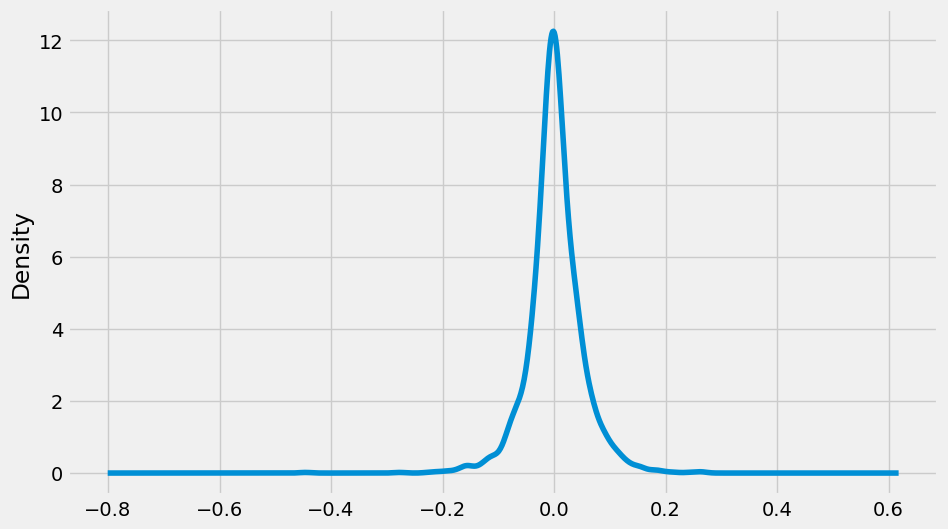

In [15]:
#Distribution of the dataset
df_change = df_data_change['change']
df_change.plot(kind='kde')

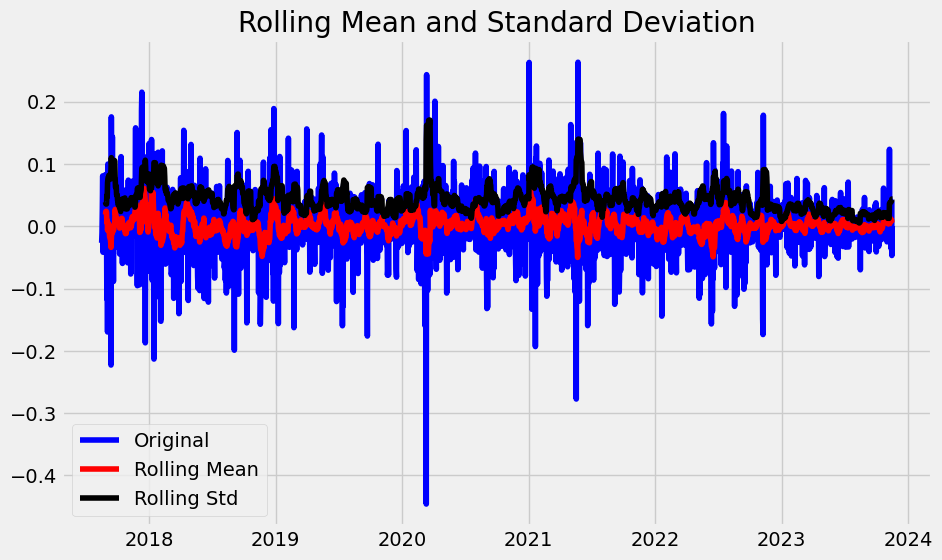

Results of dickey fuller test
Test Statistics                 -33.138554
p-value                           0.000000
No. of lags used                  1.000000
Number of observations used    2282.000000
critical value (1%)              -3.433219
critical value (5%)              -2.862807
critical value (10%)             -2.567445
dtype: float64


In [16]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_change)

<Figure size 1000x600 with 0 Axes>

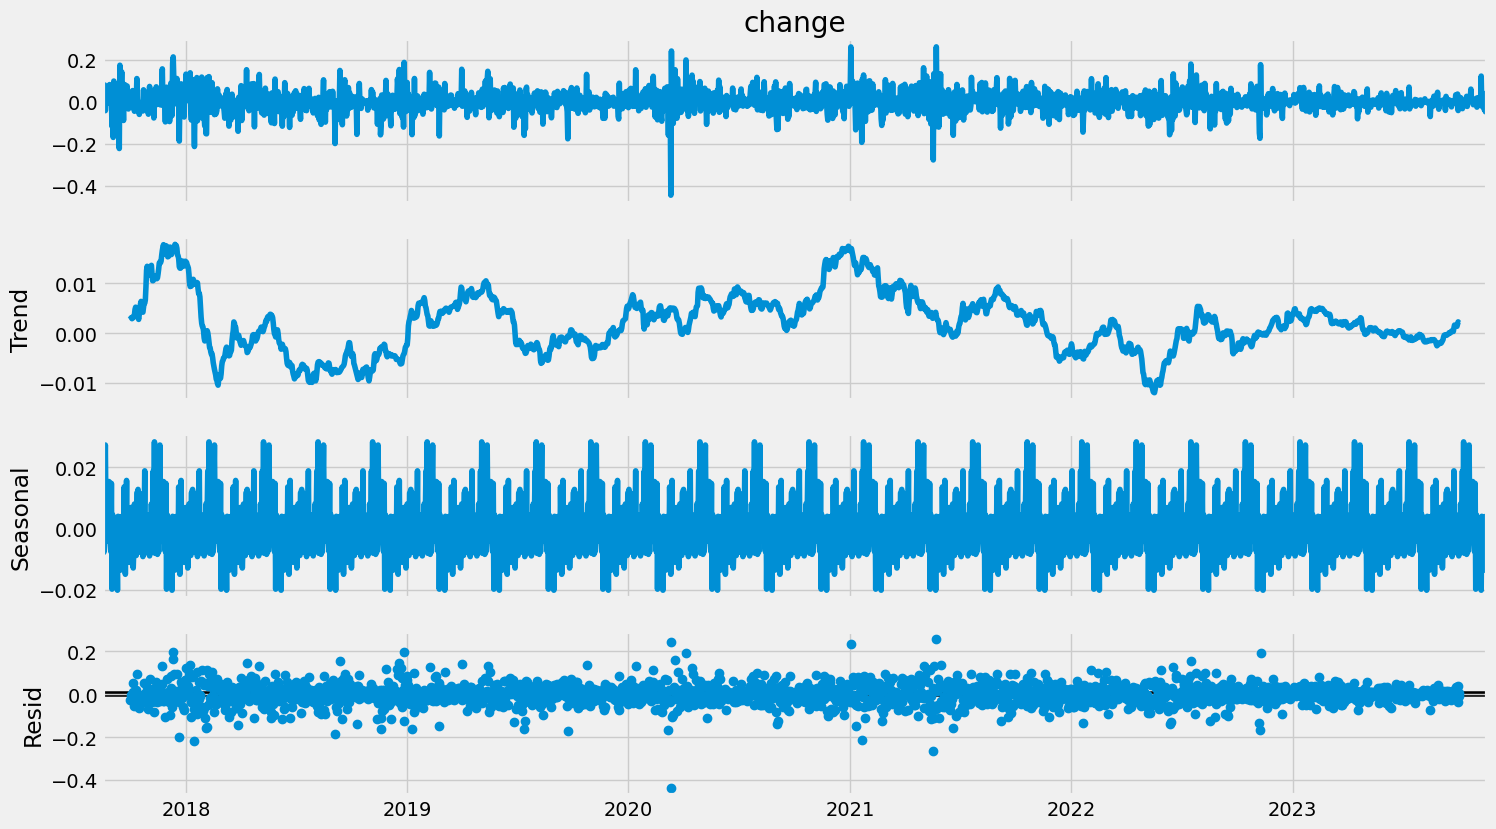

In [17]:
result = seasonal_decompose(df_change, model='additive', period=90)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

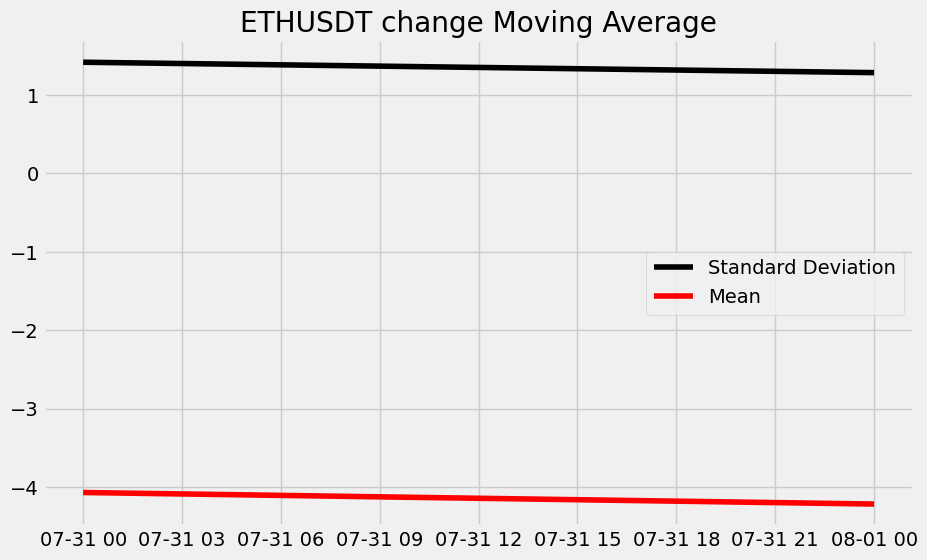

In [18]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log1 = np.log(df_change)
moving_avg = df_log1.rolling(12).mean()
std_dev = df_log1.rolling(12).std()
plt.legend(loc='best')
plt.title('ETHUSDT change Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

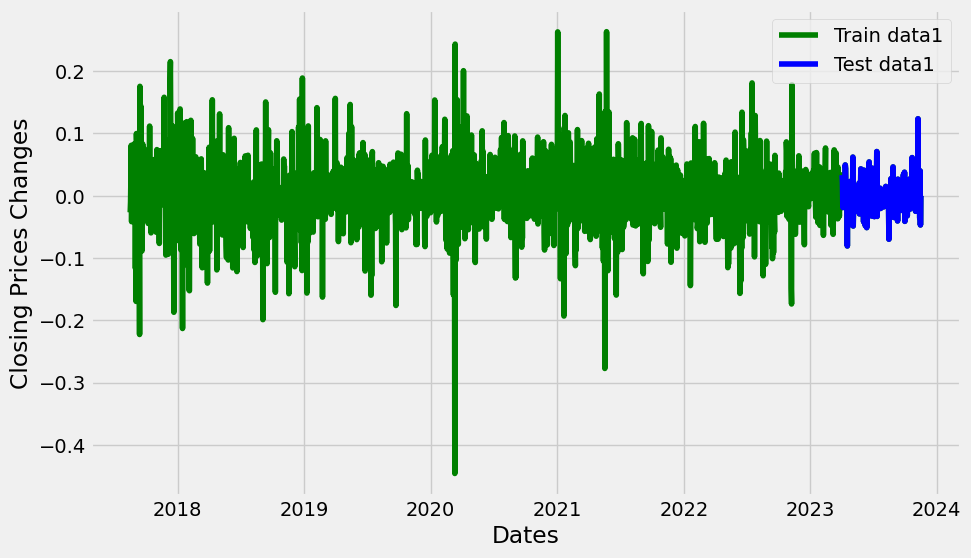

In [19]:
#split data into train and training set
train_data1, test_data1 = df_change[3:int(len(df_change)*0.9)], df_change[int(len(df_change)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices Changes')
plt.plot(df_change, 'green', label='Train data1')
plt.plot(test_data1, 'blue', label='Test data1')
plt.legend()

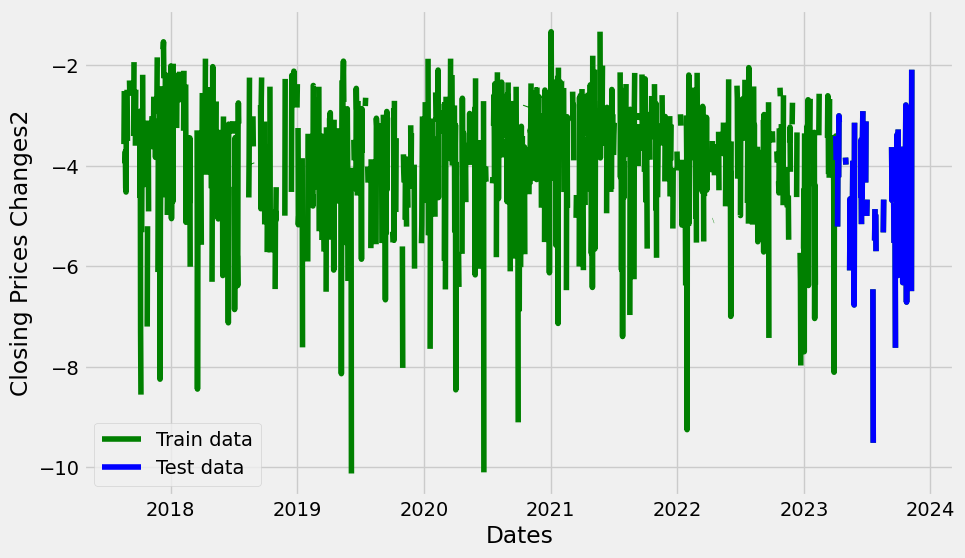

In [20]:
#split data into train and training set
train_data2, test_data2 = df_log1[3:int(len(df_log1)*0.9)], df_log1[int(len(df_log1)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices Changes2')
plt.plot(df_log1, 'green', label='Train data')
plt.plot(test_data2, 'blue', label='Test data')
plt.legend()

In [21]:
print(len(train_data1))
print(len(test_data1))


2052
229


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-6370.545, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-6377.132, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-6376.267, Time=0.15 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-6380.991, Time=0.18 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-6379.375, Time=0.31 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-6379.592, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-6378.880, Time=0.16 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-6377.393, Time=0.20 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-6382.922, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-6379.495, Time=0.45 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-6381.208, Time=0.67 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-6381.335, Time=0.42 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-6381.116, Time=0.42 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-6379.221, Time=0.65 sec

Best model:  ARIMA

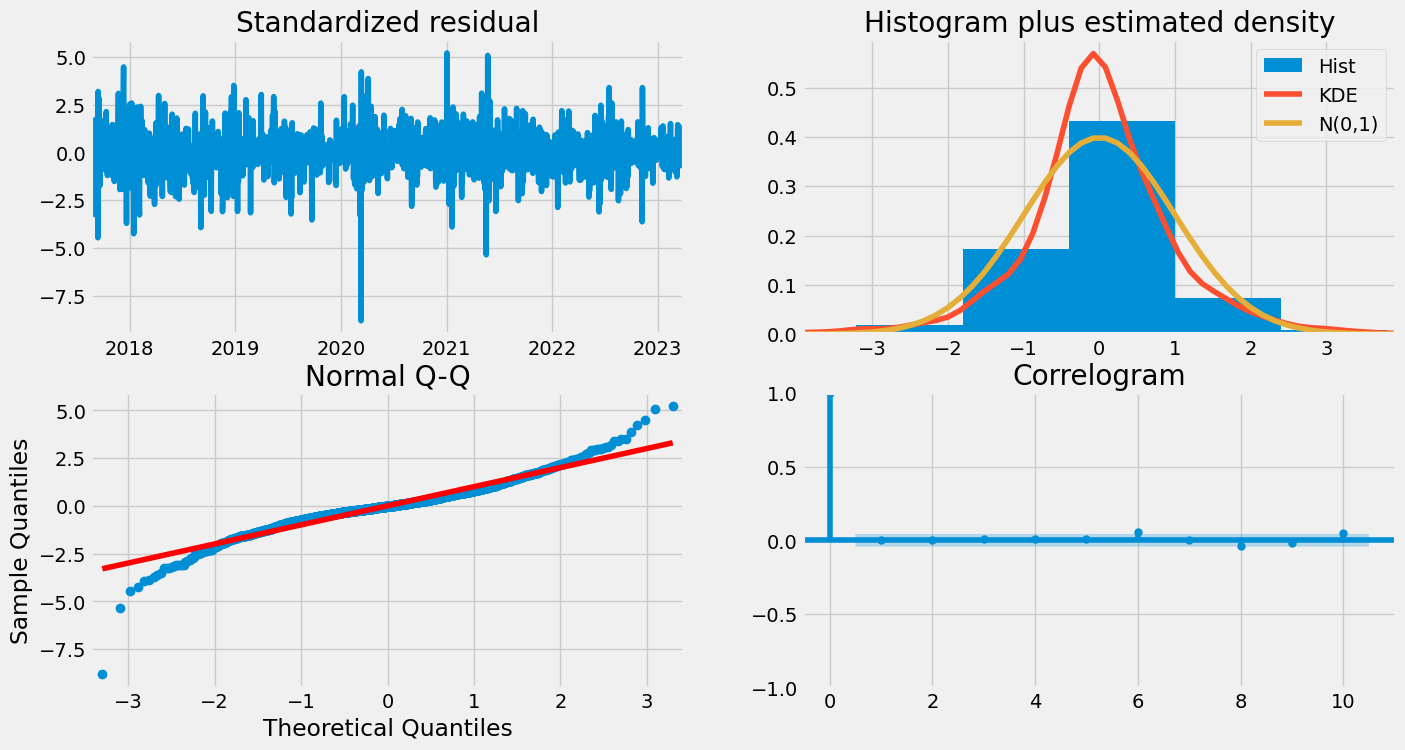

In [22]:
model_autoARIMA = auto_arima(train_data1, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=0,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [23]:
#Modeling
# Build Model
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data1, order=(2,0,0))
fitted = model.fit()
print(fitted.summary())

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 change   No. Observations:                 2052
Model:                 ARIMA(2, 0, 0)   Log Likelihood                3195.461
Date:                Tue, 21 Nov 2023   AIC                          -6382.922
Time:                        03:41:00   BIC                          -6360.416
Sample:                    08-20-2017   HQIC                         -6374.669
                         - 04-02-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      1.942      0.052   -2.05e-05       0.004
ar.L1         -0.0626      0.015     -4.088      0.000      -0.093      -0.033
ar.L2          0.0514      0.020      2.547      0.0

In [24]:
forecast_result = fitted.forecast(229, alpha=0.05)
print(forecast_result)


2023-04-03    0.000934
2023-04-04    0.002633
2023-04-05    0.002117
2023-04-06    0.002236
2023-04-07    0.002202
                ...   
2023-11-13    0.002209
2023-11-14    0.002209
2023-11-15    0.002209
2023-11-16    0.002209
2023-11-17    0.002209
Freq: D, Name: predicted_mean, Length: 229, dtype: float64


In [25]:
forecast_result = fitted.get_forecast(steps=229)
predicted_mean = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

In [26]:
fc = forecast_result.predicted_mean
se = forecast_result.se_mean
conf = forecast_result.conf_int(alpha=0.05)

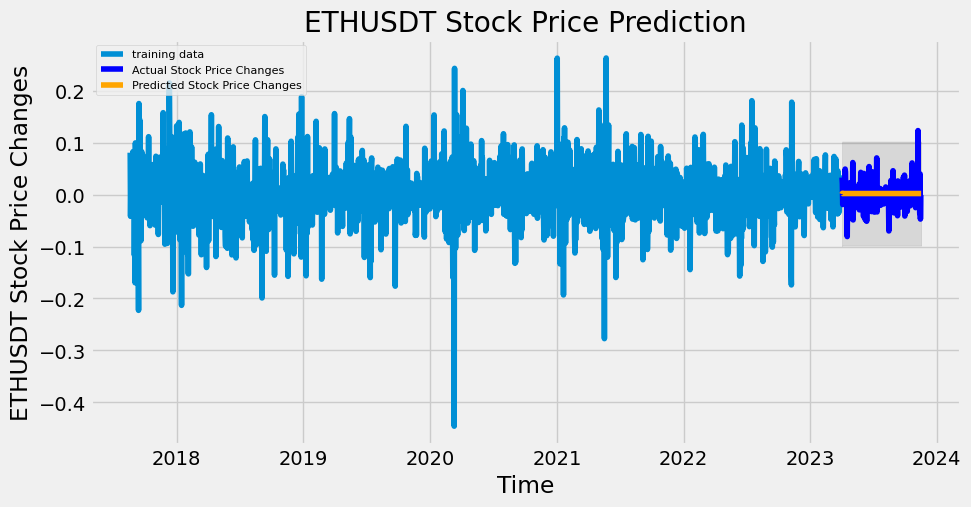

In [27]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data1.index)
lower_series = pd.Series(conf.iloc[:, 0], index=test_data1.index)
upper_series = pd.Series(conf.iloc[:, 1], index=test_data1.index)

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data1, label='training data')
plt.plot(test_data1, color = 'blue', label='Actual Stock Price Changes')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price Changes')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('ETHUSDT Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('ETHUSDT Stock Price Changes')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [28]:

# report performance
mse = mean_squared_error(test_data1, fc)
print('MSE: ' + str(mse))

mae = mean_absolute_error(test_data1, fc)
print('MAE: ' + str(mae))

rmse = math.sqrt(mean_squared_error(test_data1, fc))
print('RMSE: ' + str(rmse))

# 确保 fc 和 test_data_aligned 长度相同
fc_aligned = fc[:len(test_data1)]

# 创建一个布尔数组，标识非零值
non_zero = test_data1 != 0

# 使用位置索引计算 MAPE
mape_values = np.abs((fc_aligned[non_zero.values] - test_data1[non_zero.values]) / test_data1[non_zero.values])

# 计算 MAPE
mape = np.mean(mape_values)
print('MAPE: ' + str(mape))



MSE: 0.0004898354027098244
MAE: 0.014866155192778783
RMSE: 0.022132225435094056
MAPE: 1.5560607865923073
